# GP regression on sinusoidal data with Student-T distributed noise

- Tutorial [Gaussian Processes](https://docs.pymc.io/Gaussian_Processes.html)
- Example [Latent variable implementation](https://docs.pymc.io/notebooks/GP-Latent.html)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

In [2]:
import warnings
        
# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# set the seed
np.random.seed(4)

## Create Sinusoidal data with Student-T distributed noise


In [4]:
def sinusoid(x):
    return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
    """
      Generate noisy sinusoidal observations at a random set of points.

      Returns:
         observation_index_points, observations
    """
    index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
    index_points_ = index_points_.astype(np.float64)
    # The observed data is the latent function plus a small amount of T distributed noise
    # The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
    σ_true = 0.5
    ν_true = 2.0
    observations_ = sinusoid(index_points_) + σ_true * np.random.standard_t(ν_true, size=(num_training_points))
    return index_points_, observations_

In [5]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [6]:
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

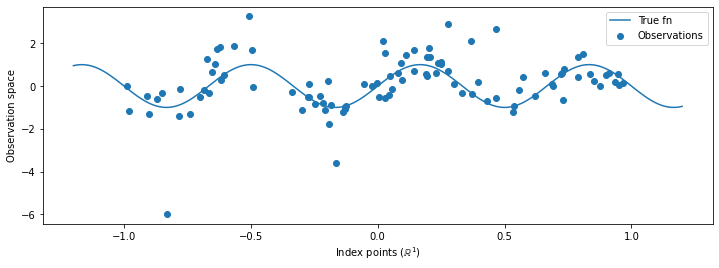

In [7]:
# Plot the true function and observations.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## Coding the model in PyMC3

A common application of Gaussian processes in machine learning is Gaussian process regression. The idea is that we wish to estimate an unknown function given noisy observations $y_1, ..., y_N$ of the function at a finite number of points $x_1, ..., x_N$. We imagine a generative process
$$ f(x) \sim GP(m(x), k(x,x'))$$

Latent Gaussian Process
$$ Pr(\theta | y) \propto \prod_{i=1}^N Pr(y_i | \theta) Pr(\theta)$$
Where $Pr(y_i | \theta) \sim t(\nu)$


Below we make use of the ExponentiatedQuadratic covariance kernel. Its form is
$$ k(x,x'):= \sigma^2 \exp \left( \frac{{\lVert}x-x'{\rVert}^2}{\lambda^2} \right)$$


In [8]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)
    # Specify the covariance function.
    cov = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)

    # Specify the GP. The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=observation_index_points_)
    
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=observations_)
    
    trace = pm.sample(1000, tune=2000, chains=2, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 124 seconds.
The acceptance probability does not match the target. It is 0.7049321966549744, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7160375263225456, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(trace)[["ℓ", "η", "f_rotated_"]].to_array() > 1.03).values
)
print(f"{n_nonconverged} variables MCMC chains appear not to have converged.")

202 variables MCMC chains appear not to have converged.


### Use conditional distribution

In [10]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", predictive_index_points_)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])

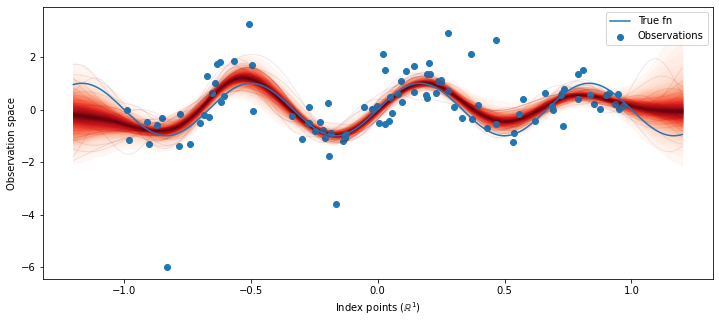

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist


plot_gp_dist(ax, pred_samples["f_pred"], predictive_index_points_)

# plot the data and the true latent function
ax.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
ax.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()